# Billboard Top 100 Data Story

_James Parks_

# 1. Introduction

On the week ending November 12, 1955, Billboard published the Top 100 chart for the first time. The Top 100 combined all aspects of a single's performance (sales, airplay and jukebox activity), based on a point system that typically gave sales (purchases) more weight than radio airplay. The Billboard Hot 100 is still the standard by which a song's popularity is measured today. The Hot 100 is ranked by radio airplay audience impressions as measured by Nielsen BDS, sales data compiled by Nielsen Soundscan (both at retail and digitally) and streaming activity provided by online music sources.

Due to the incompleteness of the dataset for the early years, our Billboard Top 100 dataset contains the Top 100 tracks ranked by popularity for every week between September 8, 1958 and January 8, 2017. 

**Note:** When considering yearly trends we do not include the years 1958 and 2017 due to lack of chart data.

We combine this dataset with the Spotify track audio metadata for the songs in this dataset. The metadata contains variables such as song key, tempo, time signature as well as other metrics scaled between 0 and 1 like song "danceability" and "energy". Furthermore we also obtain the lyrics for the songs in the dataset. 


** Goal: What audio features best predict song popularity?**
- Other than artist name, what audio features are associated with more popular songs?
- How has the average of the audio features of the top 100 tracks changed over time?
- What is the proportion of one-hit wonders each year?
- Is song key an indicator of song popularity?
- Is there any interesting trends in song lyrics over time?
- Have the Billboard policy changes had any noticeable affect on the charts?

# 2. Library Imports

In [1]:
#Usual Imports
import time
from time import sleep
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
# Imports for web scraping Lyrics data
from bs4 import BeautifulSoup
import urllib
import requests
# Imports for text analysis
from collections import Counter
from nltk.corpus import stopwords
# Imports for statistics
import statsmodels.stats.api as sms
import scipy.stats as stats
# Imports for machine learning
from sklearn.cluster import KMeans

# 3. Datasets 
The Billboard Top 100 dataset and accompanying Spotify metadata are taken from Decibels & Decimals https://github.com/dbfowler/billboard_volatility/tree/master/Raw%20Data. The lyric dataset was previously scraped from various websites. (We descrbe the lyric scraping procedure in Section 5.)

According to the Decibels & Decimels website there are some errors in the SpotifyID's attached to each track as well as inconsistent spelling of tracks/artist names. For example, for some tracks in the Billboard Top 100 the SpotifyID may be linked to a different version of the same song. No attempt was made to correct for these inconsistencies. 

In [2]:
billboard_data = pd.read_csv("all_charts.csv",low_memory=False)
spotify_data = pd.read_csv("audio_features.csv")
billboard_lyrics = pd.read_csv("all_lyrics.csv",encoding='latin1')

# 4. Prepare a Tidy Dataset
For this project the variables we are interested in are: chartDate, title, artist, peakPos, lastPos, weeks, rank, change and spotifyLink from billboard_data and the acousticness, danceability, duration_ms, energy, id, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature and valence variables from spotify_data.

In [3]:
billboard_sub = billboard_data[["chartDate","title","artist","peakPos","lastPos","weeks","rank","change","spotifyID"]]
spotify_sub = spotify_data[["acousticness", "danceability", "duration_ms", "energy", "id","instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature","valence"]]

We now merge the billboard and spotify datasets together by their spotifyID and id variables respectively.

In [4]:
merged_data=pd.merge(billboard_sub,spotify_sub, how="outer",left_on="spotifyID",right_on="id")
#Replace weird characters:
merged_data=merged_data.replace({'\x83': '?'}, regex=True).replace({'\x82': '?'}, regex=True).replace({'\x80\x9c': '??'}, regex=True)

Next we merge the merged dataset above with the lyrics dataset.
We first subset the lyrics data by only the artist, lyrics, source and track variables.

In [5]:
lyrics_sub=billboard_lyrics[["artist","lyrics","track","source"]]
big_dataset=pd.merge(merged_data, lyrics_sub,  how="outer",left_on=["artist","title"],right_on=["artist", "track"])

We then add a year column to facilitate the observation of yearly trends.

In [6]:
year = big_dataset.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
year_data=pd.concat([big_dataset,year],axis=1)

Let's take a look at the data:

In [7]:
year_data.head(5)

,chartDate,title,artist,peakPos,lastPos,weeks,rank,change,spotifyID,acousticness,...,loudness,mode,speechiness,tempo,time_signature,valence,lyrics,track,source,year
0,1958-08-16,Poor Little Fool,Ricky Nelson,1,1,11,1,0,33FPsMEl3UwpytDuyf9VYq,7e-01,...,-12,1,3e-02,155,4,8e-01,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,,1958
1,1958-08-23,Poor Little Fool,Ricky Nelson,1,1,11,4,-3,33FPsMEl3UwpytDuyf9VYq,7e-01,...,-12,1,3e-02,155,4,8e-01,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,,1958
2,1958-08-30,Poor Little Fool,Ricky Nelson,1,4,11,6,-2,33FPsMEl3UwpytDuyf9VYq,7e-01,...,-12,1,3e-02,155,4,8e-01,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,,1958
3,1958-09-06,Poor Little Fool,Ricky Nelson,1,6,11,5,+1,33FPsMEl3UwpytDuyf9VYq,7e-01,...,-12,1,3e-02,155,4,8e-01,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,,1958
4,1958-09-13,Poor Little Fool,Ricky Nelson,1,5,11,6,-1,33FPsMEl3UwpytDuyf9VYq,7e-01,...,-12,1,3e-02,155,4,8e-01,\r\r\r\r\nI used to play around with hearts th...,Poor Little Fool,,1958


# 5. Lyric Scraping Step
We describe the steps taken to obtain the billboard_lyrics dataframe.
First we created a subset of individual tracks from the merged_data dataframe by subsetting by the "title" and "artist" variables.

In [8]:
search_data=merged_data.groupby(["title","artist"]).size().reset_index()

## How many songs are in the dataset?

In [9]:
len(search_data)

27588

We have 27588 individuals tracks in the Billboard Top 100 that we must cycle through. From the artist and track name for each track we created different "typical" lyrics urls from a variety of lyric websites to attempt to extract the lyrics using the beautiful soup python library.

## Scraping the lyrics
The lyric scraping process detailed below was quite time consuming so we broke up the lyrics dataframes into 18 different files.

In [ ]:
lyrics_data = pd.DataFrame()
lower_limit =0
upper_limit =27588
# Our lyrics dataset files have the following format:
lyrics_table = 'lyrics-' +str(lower_limit)+"-"+ str(upper_limit)+'.csv'
start = time.time()
for row in range(lower_limit,upper_limit):
    artist_raw = search_data.iloc[row,1]
    artist_noand=artist_raw.replace(" &","").replace(". ","-").replace("Ã©","e").replace("$", "s")
    # We only consider the first listed artist.
    artist_array = re.split(r'.Featuring+', artist_noand) 
    track_raw=search_data.iloc[row,0]
    # We replace extended latin characters that caused errors when trying to make website requests.
    track_name=track_raw.replace("Ã\x83Â¶","oe").replace("Ã©","e").replace("ÃÂ©","e").replace("ÃÂ³",'o')
    track_name=track_name.replace("ÃÂ¡","a").replace("ÃÂ±","n").replace("Ã\x83â\x80\x9c","o").replace("ÃÂ¿DÃÂ²","do").replace("ÃÂ","a")
    track_name=re.sub(r'\&\s', '', track_name).replace("$", "s").replace("#","")
    track_name=re.sub(r'S\*\*t', 'Shit',track_name) # Replace profanity
    # Remove special characters that don't show up in website urls.
    track_name=re.sub(r'\(|\)|\'|\|\.|\"|\,', '',track_name).lower() 
    # We now try to scrape five different lyrics sites using predictable urls based on the artist and track names.
    artist_first_letter=artist_array[0][0]
    # The formatting for lyricsmode.com 
    artist_mode = re.sub(r'\s|\.|-', '_',artist_array[0]).replace(",","").lower()
    track_mode = re.sub(r'\s', '_',track_name)
    # The track formatting for songlyrics.com and metrolyrics.com is the same.
    # The artist formatting is different if the band starts with "The ".
    artist_song = re.sub(r'\s|\.', '-',artist_array[0]).replace(",","").lower()
    track_songmetro = re.sub(r'\s', '-',track_name)
    track_az = re.sub(r'\s', '',track_name)  # The track formatting for azlyrics.com
    artist_mmatch = re.sub(r'.And', '',artist_array[0]) # The artist formatting for musixmatch.com
    artist_mmatch = re.sub(r'\s|\.', '-',artist_mmatch).replace(",","").lower()
    # The urls for bands that start with "The " are formatted differently.
    if artist_array[0].startswith("The "):
        the_array = re.split(r'The ',artist_array[0])
        artist_az = re.sub(r'\'|\s|\.|-|\,', '',the_array[1]).lower()
        artist_metro = re.sub(r'\.', '-',the_array[1]).replace(",","").replace(" ","-").lower()
    else:
        artist_az = re.sub(r'\'|\s|\.|-|\,', '',artist_array[0]).lower()
        artist_metro=artist_song
    # metrolyrics.com is inconsistent in whether it keeps "The " in the url so we have two possibilities.    
    url_metro_one = 'http://www.metrolyrics.com/'+track_songmetro+'-lyrics-'+artist_metro+'.html'
    url_metro_two = 'http://www.metrolyrics.com/'+track_songmetro+'-lyrics-'+artist_song+'.html'
    url_songlyrics = 'http://www.songlyrics.com/'+artist_song+'/'+track_songmetro+'-lyrics/'
    url_mode= 'http://www.lyricsmode.com/lyrics/'+artist_first_letter+'/'+artist_mode+'/'+track_mode+'.html'
    url_music_match = 'https://www.musixmatch.com/lyrics/' + artist_mmatch + '/' + track_songmetro
    url_azlyrics="http://www.azlyrics.com/lyrics/"+artist_az+"/"+track_az+".html"
    # These are our list of lyric urls and the hypothetical location of the lyrics text on the websites.
    URLS=[url_metro_one,url_metro_two,url_songlyrics,url_mode, url_azlyrics, url_music_match]
    lyriclocations = ['lyrics-body-text', 'lyrics-body-text','songLyricsDiv','lyrics_text',"azlyrics",'mmatch']
    choice =""
    for u in range(0,len(URLS)):
        # We now cycle through each possbile url until we get a match.
        # We then scrape the lyric text from the website using beautiful soup.
        lyrics_request = urllib.request.Request(URLS[u],headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:52.0) Gecko/20100101 Firefox/52.0'})
        try:
            lyrics_web = urllib.request.urlopen(lyrics_request)
            lyrics_code = lyrics_web.read()
            soup = BeautifulSoup(lyrics_code, 'html.parser')
            if u==4:
                lyrics_array = soup.find_all("div", class_="")
            elif u == 5:
                lyrics_array = soup.find_all(class_="mxm-lyrics__content")
            else:
                lyrics_array = soup.find_all(id=lyriclocations[u])
            lyrics_text=""
            for lyrics in lyrics_array:
                lyrics_text += lyrics.get_text()
            # Some websites exist with no lyrics where the text is "\r\n ", "\r\r\n ", "\r\r\r\n ", or "\r\r\r\r\n " or "\n".
            if lyrics_text != "" and lyrics_text != "\r\n " and lyrics_text != "\n" and lyrics_text != "\r\r\n " and lyrics_text != "\r\r\r\n " and lyrics_text != "\r\r\r\r\n ":
                choice=u
                break
        except urllib.request.HTTPError as e:
            lyrics_text=""
            pass        
    add_frame = {"artist":artist_raw, "track": track_raw, "lyrics":lyrics_text, "source":choice}
    lyrics_data = lyrics_data.append(add_frame,ignore_index=True)
    # In order to not overwhelm the websites we have a delay of 45 seconds every 50 requests.
    if row%50==0 and row!=lower_limit and row!=upper_limit:
        sleep(45)
delta = time.time() - start
print ("features retrieved in %.2f seconds" % (delta,))
lyrics_data.to_csv(lyrics_table)

## Lyrics Wrangling Step
Now that we have several files we must join them all together. The lyrics scraping process created 18 different csv files for the lyrics that we then joined together using the code below. 

In [ ]:
lyrics_all=pd.DataFrame()
lyrics_one = pd.read_csv('lyrics-0-100.csv',  encoding='latin1')
lyrics_two = pd.read_csv('lyrics-100-1000.csv',  encoding='latin1')
lyrics_all = pd.concat([lyrics_one,lyrics_two])
lyrics_new = pd.read_csv('lyrics-1000-1096.csv',  encoding='latin1')
lyrics_all = pd.concat([lyrics_all,lyrics_new])
# There are several more to join here until:
lyrics_new=pd.read_csv('lyrics-27587-27588.csv',encoding='latin1')
lyrics_all = pd.concat([lyrics_all,lyrics_new])

## Importing the Lyrics
From our lyrics_all dataset above we subsetted to just the important columns and created a completed csv file that we imported in section 3.

In [ ]:
lyrics_subset=lyrics_all[["artist","lyrics","source","track"]].reset_index()
lyrics_subset.to_csv('all_lyrics.csv')

# 6. Exploratory Data Analysis on the Billboard Top 100 chart data

## What type of data do we have?

In [10]:
year_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304643 entries, 0 to 304642
Data columns (total 27 columns):
chartDate           304643 non-null object
title               304643 non-null object
artist              304643 non-null object
peakPos             304643 non-null int64
lastPos             304643 non-null int64
weeks               304643 non-null int64
rank                304643 non-null int64
change              304643 non-null object
spotifyID           258820 non-null object
acousticness        258820 non-null float64
danceability        258808 non-null float64
duration_ms         258820 non-null float64
energy              258820 non-null float64
id                  258820 non-null object
instrumentalness    258820 non-null float64
key                 258820 non-null float64
liveness            258820 non-null float64
loudness            258820 non-null float64
mode                258820 non-null float64
speechiness         258808 non-null float64
tempo               258

## Variable Descriptions

** chartDate:** Always on a Saturday. Represents the ranking for the preceding week.

** title: ** Title of the song (Note that this title might be inconsistent with the title from the Spotify dataset.)

** artist: ** Artist of the song (Note that if the track features another artist that will be counted separately.)

** peakPos: ** The highest position the track ever reached on the charts.

** lastPos: ** The previous position on the track. A value of zero could mean that this is a new song that never charted before or that the song is re-entering the charts. 

** weeks: ** There is some inconsistency with this data. For some entries it is the number of weeks the song has been on the chart up to that point, but for some older entries it is the total number of weeks the song was on the charts.

** rank: ** The current rank of the song for that week.

** change: ** The change in the rank since the previous week. Songs that were not on the charts the previous week are either "New", "Re-Entry" or "Hot Shot Debut".

** spotifyID: ** The SpotifyID for the track for the Billboard dataset.

** acousticness: ** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

** danceability: ** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

** duration_ms: ** The duration of the track in milliseconds.

** energy: **  Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

** id: ** The Spotify ID for the track for the Spotify audio features dataset.

** instrumentalness: **  Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

** key: ** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

** liveness: ** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

** loudness: ** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

** mode: ** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

** speechiness: ** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

** tempo: ** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

** time signature: ** An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

** valence: ** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

** lyrics: ** Lyrics scraped from several online resources.

** track: ** The title of the song.

** source: ** Integer representing source for the lyrics.

** year: ** The first year the track appeared on the Billboar Top 100 chart.

## How many weeks of chart data do we have?

In [11]:
len(big_dataset.groupby("chartDate").count())

3048

## How many unique tracks and unique artists make the Billboard Top 100 each year?

Note that for tracks that feature multiple artists, we only count the main artist when measuring unique artists.

In [12]:
artist_count=year_data.groupby(["artist","title","year"]).mean().reset_index()
for row in range(0,len(artist_count)):
    artist_array = re.split(r'.Featuring+', artist_count.iloc[row,0])
    artist_count.iloc[row,0]=artist_array[0]
yearly_track_count = artist_count.groupby(["year"]).count().reset_index()
yearly_tracks=pd.DataFrame()
for year_row in range(1958,2017):
    year_frame=artist_count[artist_count.year==year_row]
    unique_artist=len(year_frame.artist.unique())
    add_frame = {"year":year_row, "unique_artist_count": unique_artist}
    yearly_tracks = yearly_tracks.append(add_frame,ignore_index=True)

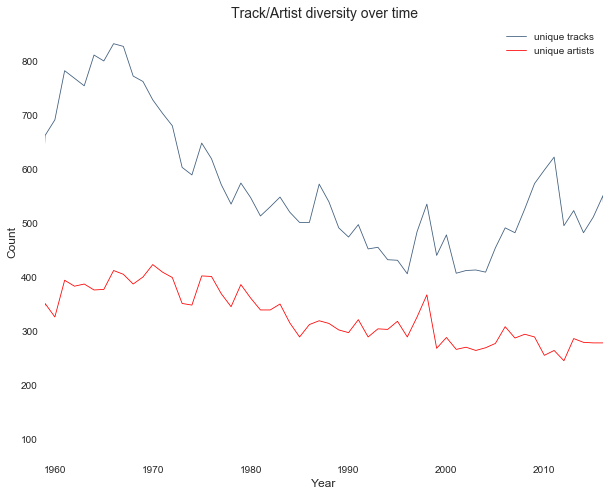

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(yearly_track_count.year, yearly_track_count.artist, color="#3F5D7D", linewidth=0.8,label="unique tracks")
plt.plot(yearly_tracks.year, yearly_tracks.unique_artist_count, color="red", linewidth=0.8,label="unique artists")
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Track/Artist diversity over time', fontsize=14)
plt.xlim([1959,2016])
plt.legend()
plt.show()

We see that during the 1960's there were many more unique tracks making the Billboard Top 100. This could be a attributed to the lack of options for people to listen to music and radio was the main medium so listeners would likely tire of the same songs more quickly so it's possible that songs didn't stay on the charts for very long. 

The number of unique tracks steadily declined until 1997 where there was a slight uptick again and the amount increased again through the mid 2000's which could be a result in the change in how song popularity is counted by taking internet download/streaming into account.

The number of unique artists followed a similar trajectory although the difference was not that large and without a noticeable increase in the 2000's.

** We expect to see an inverse relationship between the number of unique tracks in the Billboard Top 100 and the average number of weeks a track spends on the chart. **

In [14]:
week_count=year_data.groupby(["artist","title", "year"]).max().reset_index()
week_average=week_count.groupby(["year"]).mean().reset_index()

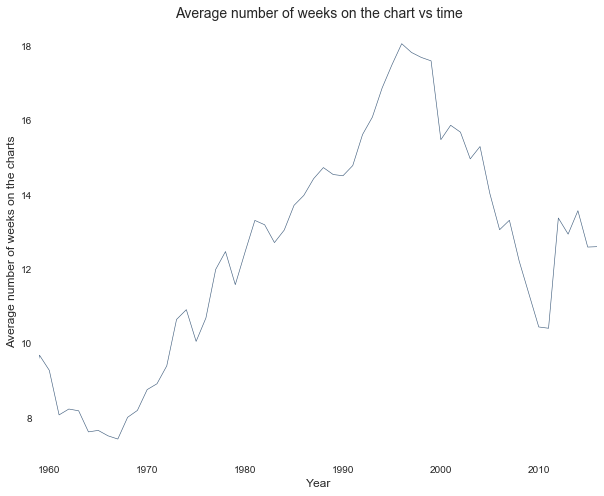

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(week_average.year, week_average.weeks, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average number of weeks on the charts', fontsize=12)
plt.title('Average number of weeks on the chart vs time', fontsize=14)
plt.xlim([1959,2016])
plt.show()

As we expected, tracks began spending a lot more time on the charts on average starting in the late 1960's up until the mid 1990's where the average decreased until 2011. 

## What is the relationship between the average number of weeks spent on the chart versus the number of unique tracks?

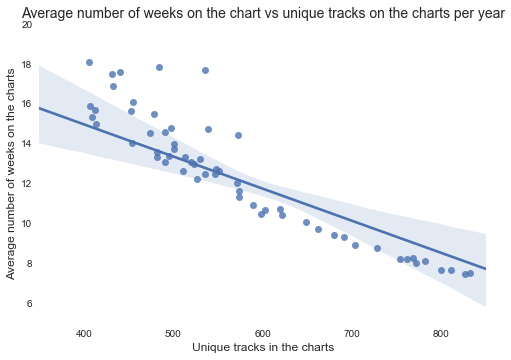

In [16]:
ax= sns.regplot(yearly_track_count.artist,y=week_average.weeks)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.xlabel('Unique tracks in the charts', fontsize=12)
plt.ylabel('Average number of weeks on the charts', fontsize=12)
plt.title('Average number of weeks on the chart vs unique tracks on the charts per year', fontsize=14)
# The limits on the x-axis are chosen to ignore the data from 1958 and 2017 which are incomplete.
plt.xlim([350,850])
plt.ylim([5,20])
plt.show()
sns.plt.show()

We see the expected negative correlation between the two features.

Another important feature to investigate is the number of one-hit wonders each year. Less one-hit wonders would imply that artist name would be one of the biggest indicators of having a Top 100 hit. 

In [17]:
one_hits=year_data.groupby(["artist","title"]).count().reset_index()
one_hits=one_hits[["artist","title"]]
# We only count the main artist when considering tracks featuring multiple artists.
for row in range(0,len(one_hits)):
    artist_array = re.split(r'.Featuring+', one_hits.iloc[row,0])
    one_hits.iloc[row,0]=artist_array[0]
one_hits_new=one_hits.groupby(["artist"]).count().reset_index()
hit_count=one_hits_new.sort_values(by="title",ascending=False)
hit_count.columns=["artist","counted"]
hit_count.head(15)

,artist,counted
2524,Glee Cast,205
1899,Drake,78
6151,Taylor Swift,67
331,Aretha Franklin,66
6272,The Beatles,65
2037,Elton John,62
4155,Madonna,59
6956,The Rolling Stones,57
6000,Stevie Wonder,55
6271,The Beach Boys,54


The big take away from this is how massively popular Glee was. In the five years between 2009 and 2013 they had 205 songs make the Top 100 which is more than double the number of hits for the next highest ranked artist. Drake and Taylor Swift make up the next two highest positions despite having smaller discographies than a lot of the older artists, but due to the way that songs are currently counted, for big artists today every song on their albums can end up charting whereas in the past not every song on the album was released as a single. This suggests that artist name may be by far the biggest predictor of whether or not a song will make the top 100.

In [20]:
print("{0:.2f}%".format(len(hit_count[hit_count.counted==1])/len(hit_count)*100) + " of artists have one song in the Top 100.")
print("{0:.2f}%".format(len(hit_count[hit_count.counted==2])/len(hit_count)*100) + " of artists have two songs in the Top 100.")
print("{0:.2f}%".format(len(hit_count[hit_count.counted==3])/len(hit_count)*100) + " of artists have three songs in the Top 100.")
print("{0:.2f}%".format(len(hit_count[hit_count.counted==4])/len(hit_count)*100) + " of artists have four songs in the Top 100.")
print("{0:.2f}%".format(len(hit_count[hit_count.counted==5])/len(hit_count)*100) + " of artists have five songs in the Top 100.")

53.37% of artists have one song in the Top 100.
15.60% of artists have two songs in the Top 100.
8.10% of artists have three songs in the Top 100.
4.56% of artists have four songs in the Top 100.
3.16% of artists have five songs in the Top 100.


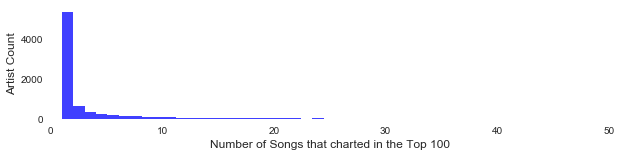

In [21]:
fig = plt.figure(figsize=(10, 12))
axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.hist(one_hits_new.title, color="blue", bins=200,alpha=0.75)
plt.xlim(0,50)
plt.xlabel("Number of Songs that charted in the Top 100", fontsize=12)
plt.ylabel('Artist Count', fontsize=12)
plt.show()

From this we see that although there are a few artists with more than 30 songs that charted in the top 100, the majority of songs in the Top 100 come from artists that are one-hit wonders.

## What is the percentage of one hit wonders in the Top 100 chart each year? 

In [22]:
one_hits=artist_count.groupby(["artist"]).count().reset_index()
# We only count the main artist when considering tracks featuring multiple artists.
for row in range(0,len(one_hits)):
    artist_array = re.split(r'.Featuring+', one_hits.iloc[row,0])
    one_hits.iloc[row,0]=artist_array[0]
one_hits_new=one_hits.groupby(["artist"]).sum().reset_index()
# We make a logistic column of 1 if the artist has only one track in the Billboard Top 100 for all years and
# and 0 if the artist appears as the main artist on at least two different tracks in any years.
one_hits_count=pd.DataFrame()
for row in range(0,len(one_hits_new)):
    if one_hits_new.iloc[row,1]>1:
        one_hit_id=0
    else:
        one_hit_id=1
    add_frame = {"artist":one_hits_new.iloc[row,0], "one_hit_wonder": one_hit_id}
    one_hits_count = one_hits_count.append(add_frame,ignore_index=True)
num_hits=artist_count.groupby(["artist","year"]).count().reset_index()
one_hit_merge=pd.merge(one_hits_count,num_hits, how="outer",left_on="artist",right_on="artist")
one_hit_percent=one_hit_merge.groupby("year").mean().reset_index()

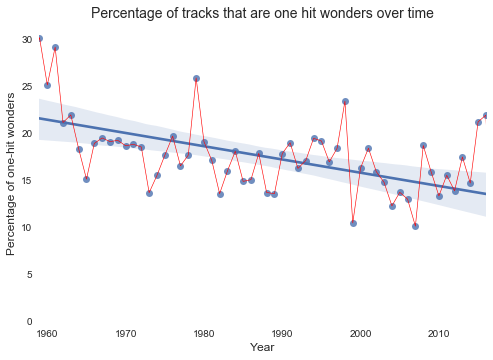

In [23]:
ax = sns.regplot(x="year",y=one_hit_percent.one_hit_wonder*100,data=one_hit_percent)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  

plt.plot(one_hit_percent.year, one_hit_percent.one_hit_wonder*100, color="red", linewidth=0.6)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage of one-hit wonders', fontsize=12)
plt.title('Percentage of tracks that are one hit wonders over time', fontsize=14)
plt.xlim([1959,2016])
sns.plt.show()
plt.show()

** The percentage of one-hit wonders seems to have decreased over time, but is this really the case? **

On December 5, 1998, the Billboard Top 100 changed from being a "singles" chart to a "songs" chart, which allowed non-single tracks to be counted. We separate the data into two sets 1959-1998 and 1999-2016 and compare the average percentage of one-hit wonders each year.

In [24]:
old_ones=one_hit_percent[1:41]
new_ones=one_hit_percent[41:-1]

## Hypothesis Test: Percentage of one-hit wonders

$$H_0: \mu_\text{old} - \mu_\text{new} = 0$$

$$H_a: \mu_\text{old} - \mu_\text{new} \neq 0$$

In [25]:
z,p= stats.ttest_ind(old_ones.one_hit_wonder, new_ones.one_hit_wonder,equal_var=False)
cm = sms.CompareMeans(sms.DescrStatsW(old_ones.one_hit_wonder), sms.DescrStatsW(new_ones.one_hit_wonder))
conf_low,conf_high =cm.tconfint_diff(alpha = 0.05,usevar='unequal')
print("Z-Statistic: ", z)
print("95% Confidence Interval: ", (conf_low,conf_high))
print("p-value: ",p)

Z-Statistic:  3.33734125542
95% Confidence Interval:  (0.012807220918658407, 0.052311307043165584)
p-value:  0.00190495805707


We obtain a p-value that is close to zero and with a statistical significance of alpha = 0.05 we obtain a 95% confidence interval that the true mean difference lies between 1.2% and 5.2%. 

** Thus we reject the null hypothesis. ** 

We conclude that the percentage of tracks on the chart coming from artists that are one-hit wonders has decreased recently but the difference is not very significant.

# 7. Exploratory Data Analysis on the Spotify Audio Metadata

## What is the percentage of songs with Spotify audio metadata?

In [26]:
print("{0:.2f}%".format(len(spotify_data)/len(search_data)*100))

78.33%


** We now plot histograms of several of the Spotify audio metadata features. **

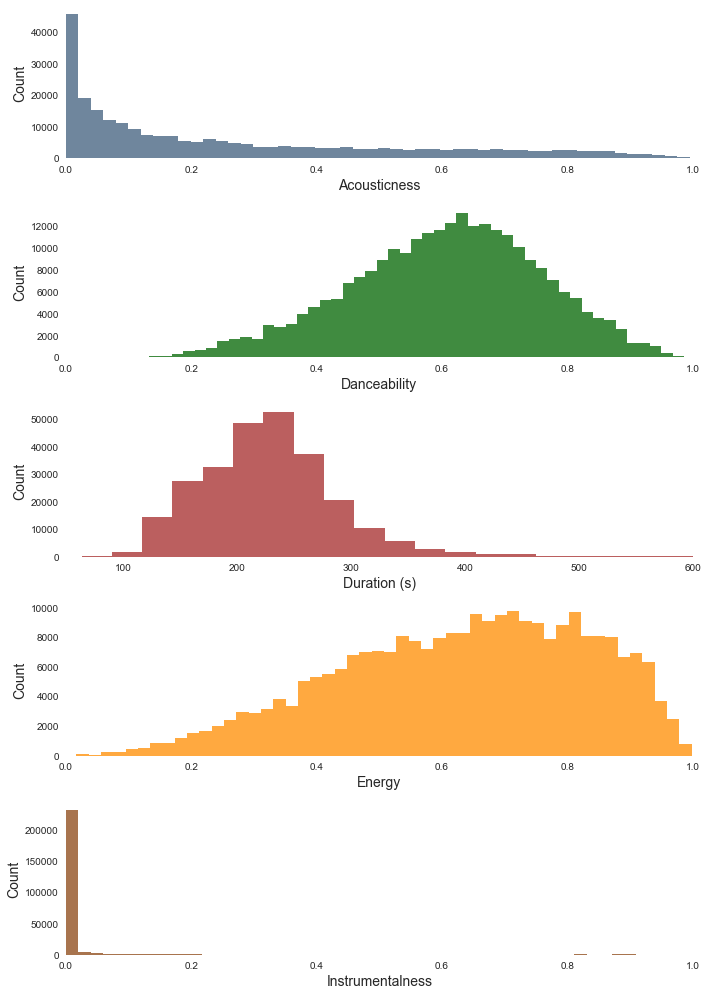

In [27]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.hist(big_dataset.acousticness.dropna(), color="#3F5D7D", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Acousticness", fontsize=14)
plt.ylabel('Count', fontsize=14)

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.xlim(0,1)
plt.hist(big_dataset.danceability.dropna(), color="#006400", bins=50,alpha=0.75)
plt.xlabel("Danceability", fontsize=14)
plt.ylabel('Count', fontsize=14)

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.hist(big_dataset.duration_ms.dropna()/1000, color="#a52a2a", bins=50,alpha=0.75)
plt.xlim(50,600)
plt.xlabel("Duration (s)", fontsize=14)
plt.ylabel('Count', fontsize=14)


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.hist(big_dataset.energy.dropna(), color="#ff8c00",bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Energy", fontsize=14)
plt.ylabel('Count', fontsize=14)

axfive=plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.hist(big_dataset.instrumentalness.dropna(), color="#8b4513",bins=50,alpha=0.75)
plt.xlabel("Instrumentalness", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("metadata_histograms.png", bbox_inches="tight"); 
plt.show()


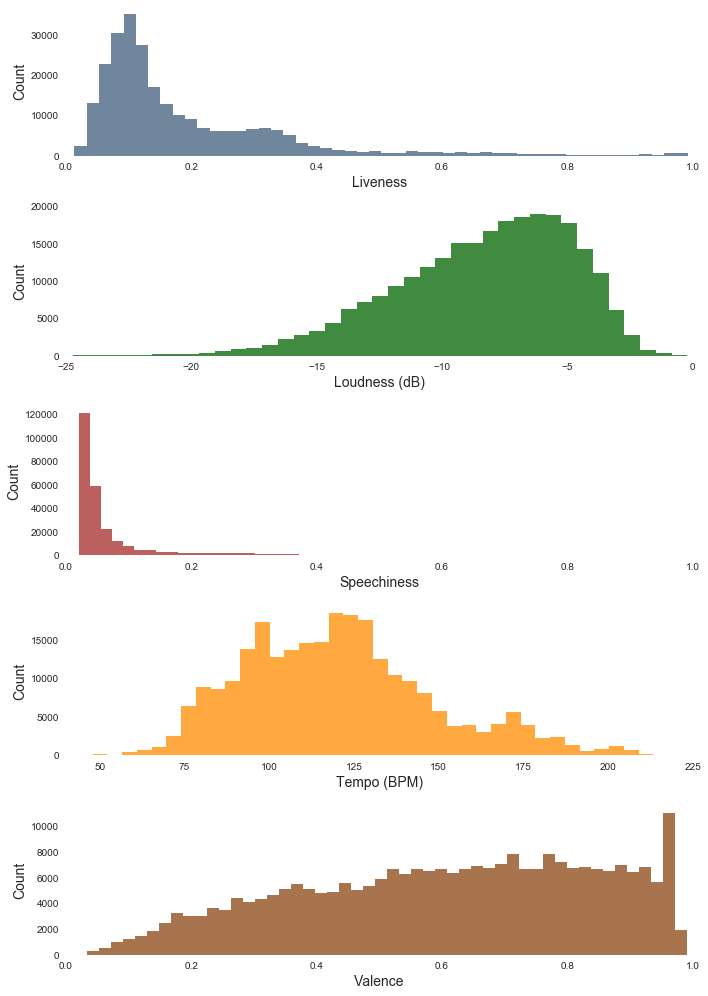

In [28]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.hist(big_dataset.liveness.dropna(), color="#3F5D7D", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Liveness", fontsize=14)
plt.ylabel('Count', fontsize=14)

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.xlim(-25,0)
plt.hist(big_dataset.loudness.dropna(), color="#006400", bins=50,alpha=0.75)
plt.xlabel("Loudness (dB)", fontsize=14)
plt.ylabel('Count', fontsize=14)

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.hist(big_dataset.speechiness.dropna(), color="#a52a2a", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Speechiness", fontsize=14)
plt.ylabel('Count', fontsize=14)


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.hist(big_dataset.tempo.dropna(), color="#ff8c00",bins=50,alpha=0.75)
plt.xlim(40,225)
plt.xlabel("Tempo (BPM)", fontsize=14)
plt.ylabel('Count', fontsize=14)

axfive=plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.hist(big_dataset.valence.dropna(), color="#8b4513",bins=50,alpha=0.75)
plt.xlabel("Valence", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("metadata_histograms_2.png", bbox_inches="tight"); 
plt.show()



** Things of Note:**

Acousticness, instrumentalness and speechiness all seem to be heavily skewed towards zero. This is because songs on the billboard chart usually feature electric instruments, have lyrics and are composed of very few spoken words parts respectively. On the other hand, duration, liveness,loudness and especially danceability, energy and tempo seem to be normally distributed. It would make sense that the latter features would be closely related since songs with more energy and a faster tempo are easier to dance to up to a certain point. 

## What can we say about tracking audio metadata features over time?

We subset the year data set so that we only consider the first week that the song entered the chart. 

In [29]:
year_data_sub=year_data[year_data.lastPos==0]
audio_means=year_data_sub.groupby(["year"]).mean().reset_index()

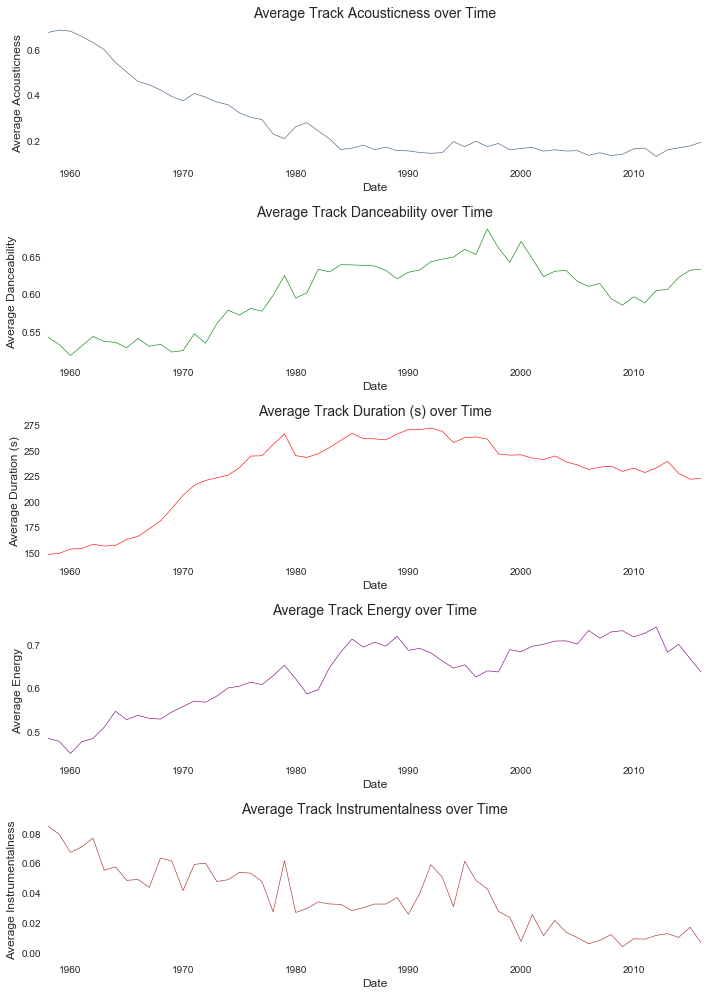

In [30]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means.year, audio_means.acousticness, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Acousticness', fontsize=12)
plt.title('Average Track Acousticness over Time', fontsize=14)
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means.year,audio_means.danceability, color="green", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Danceability', fontsize=12)
plt.title('Average Track Danceability over Time', fontsize=14)
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.duration_ms/1000, color="red", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Duration (s)', fontsize=12)
plt.title('Average Track Duration (s) over Time', fontsize=14)
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.energy, color="purple", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Energy', fontsize=12)
plt.title('Average Track Energy over Time', fontsize=14)
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means.year,audio_means.instrumentalness, color="brown", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Instrumentalness', fontsize=12)
plt.title('Average Track Instrumentalness over Time', fontsize=14)
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()


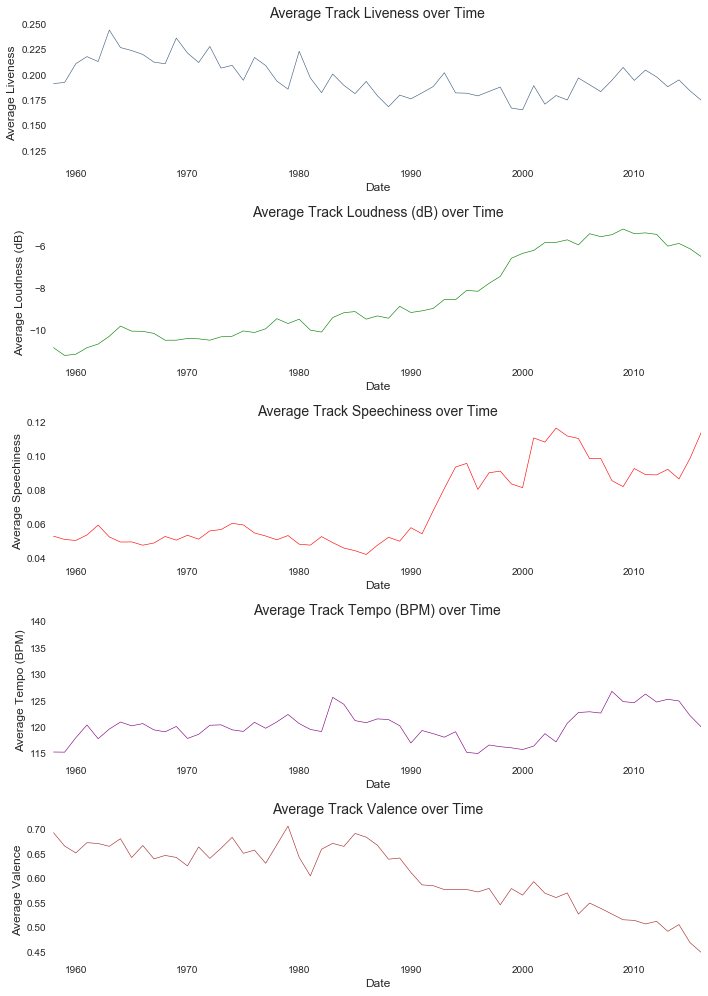

In [31]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means.year, audio_means.liveness, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Liveness', fontsize=12)
plt.title('Average Track Liveness over Time', fontsize=14)
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means.year,audio_means.loudness, color="green", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Loudness (dB)', fontsize=12)
plt.title('Average Track Loudness (dB) over Time', fontsize=14)
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.speechiness, color="red", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Speechiness', fontsize=12)
plt.title('Average Track Speechiness over Time', fontsize=14)
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.tempo, color="purple", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Tempo (BPM)', fontsize=12)
plt.title('Average Track Tempo (BPM) over Time', fontsize=14)
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means.year,audio_means.valence, color="brown", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Valence', fontsize=12)
plt.title('Average Track Valence over Time', fontsize=14)
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

** Things of Note:**

_Acousticness_: Most songs had a higher acousticness score in the 60's possibly due to the popular of rockabilly and rock and roll which steadily declined through the 70's and 80's as more electronic instruments were added.

_Danceability_: Steadily increased through the 70's possibly due to the popularity of disco and continued increasing through the 80's and 90's.

_Duration_: The average length of a song was around 2 and half minutes in the 1960's possibly tied to 7" EP format that singles were released on and increased up to a lenghth around 4 and a half minutes through the 70's until the 80's possibly as a result of the popularity of more complicated rock songs.

_Energy_ and _Instrumentalness_: Songs have become more energetic over time, possibly related to becoming more danceable and less instrumental possibly related to the increase in speechiness.

_Loudness_: We see a sharp increase in the 90's of Loudness which can be attributed to the popularity of the CD format and  producers making songs louder so that tracks would stand out more on the radio.

_Speechiness_ and _Valence_: Speechiness increased a lot during the 90's as rap became more popular while _Valence_ decreased possibly as a result of the growing popularity of grunge and continued through the 2000's.

## Is there any correlation between the audio metadata features?

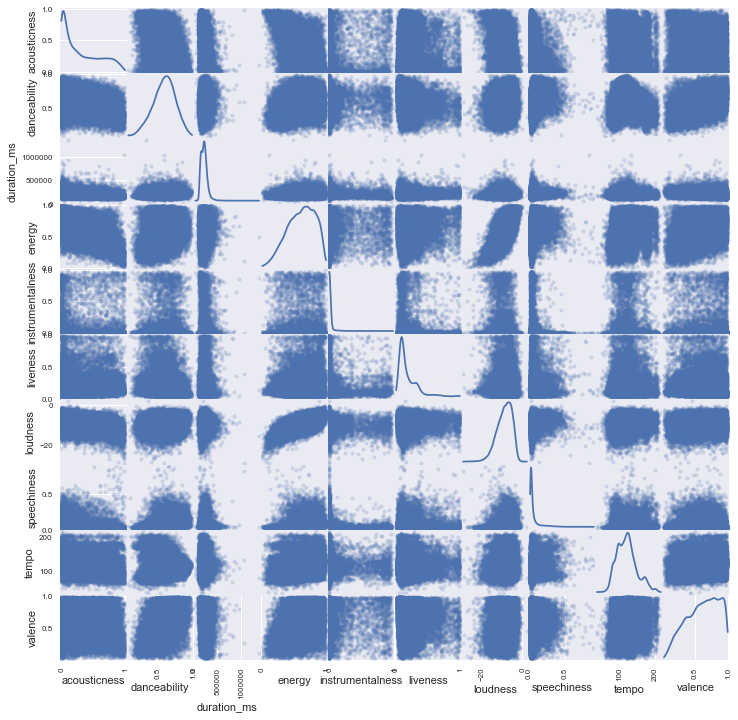

In [33]:
audio_data=spotify_data[["acousticness", "danceability", "duration_ms", "energy" ,"instrumentalness", "liveness", "loudness", "speechiness", "tempo","valence"]].dropna()
scatter_matrix(audio_data,alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

** Things of note: **
We see that instrumentalness and speechiness appears to be more of a binary relationship and a clear positive relationship between loudness and energy. On the other hand, the relationship between danceability and energy does not to be as strong as we expeccted.

In [34]:
stats.linregress(audio_data.loudness,audio_data.energy)

LinregressResult(slope=0.039646173964458034, intercept=0.96526390111282057, rvalue=0.70557549820537102, pvalue=0.0, stderr=0.00027087751352888867)

** We also investigate the relationship between tempo, energy and danceability **

In [35]:
print(stats.linregress(audio_data.tempo,audio_data.energy))
print(stats.linregress(audio_data.danceability,audio_data.energy))
print(stats.linregress(audio_data.tempo,audio_data.danceability))

LinregressResult(slope=0.0011961975749651516, intercept=0.4745726407110834, rvalue=0.16482287572566318, pvalue=1.9259596644321064e-131, stderr=4.8696459369906679e-05)
LinregressResult(slope=0.29449061429174933, intercept=0.44463192161491527, rvalue=0.22052148610074054, pvalue=3.0173202600750674e-236, stderr=0.0088611084249699303)
LinregressResult(slope=-0.0008763268470549047, intercept=0.695401676272563, rvalue=-0.16125056084649148, pvalue=8.1086504323704774e-126, stderr=3.6486876546163726e-05)


** For loudness and energy we get an r^2 value of 0.7055 which indicates that there is indeed a strong positive relationship. For the others the correlation is not very strong. **

## ** What is the most popular key? **

In [36]:
key_data=year_data.groupby(["key","mode"]).count().reset_index()
key_name_list = pd.Series(["Cm","C","C♯m","C♯","Dm","D","D♯m","D♯","Em","E","Fm","F","F♯m","F♯","Gm","G","G♯m","G♯","Am","A",'A♯m',"A♯","Bm","B"])
key_name_list=key_name_list.rename("key_name")
key_data=pd.concat([key_data,key_name_list],axis=1)

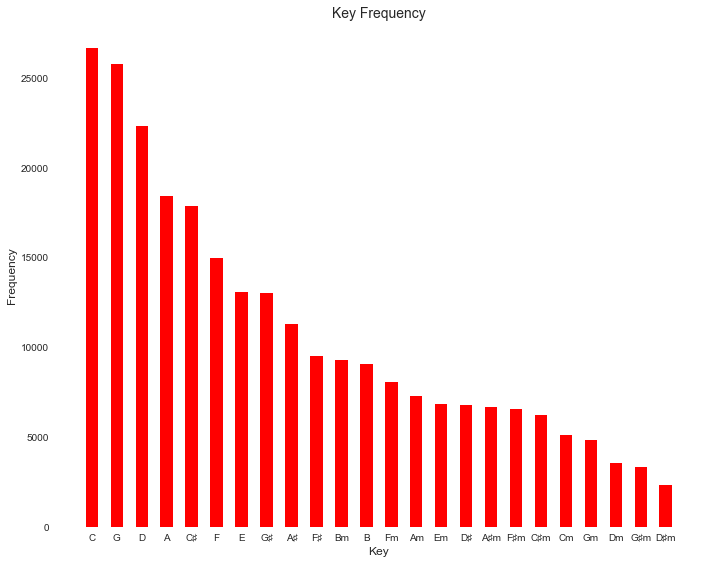

In [37]:
key_data=key_data.sort_values(by="year",ascending=False)
key_list=key_data.key_name
y_pos = np.arange(len(key_list))
fig,axone=plt.subplots(figsize=(10, 8))
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.bar(y_pos, key_data.year, width=0.5,color="red")
plt.xticks(y_pos,key_data.key_name)
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Key Frequency',fontsize=14)
plt.tight_layout()
plt.show()

** We see that most popular songs are in the key of C major closely followed by G major. **
This is likely a result of the fact that these keys are easy to play on both piano and guitar.
In fact many songs are not only in the same key, but also the same chord progression as well. See this song https://www.youtube.com/watch?v=oOlDewpCfZQ by the Axis of Awesome for reference.

It's also clear that major keys are much more popular than songs in minor keys.


**Note** that this differs slightly from the analysis of all songs on Spotify which found that the most popular key is G major. 


https://insights.spotify.com/us/2015/05/06/most-popular-keys-on-spotify/ 

In [38]:
time_data=year_data.groupby(["time_signature"]).count().reset_index().sort_values(by="year",ascending=False)
time_data["percent"]=time_data.year/len(year_data[year_data.time_signature.notnull()])

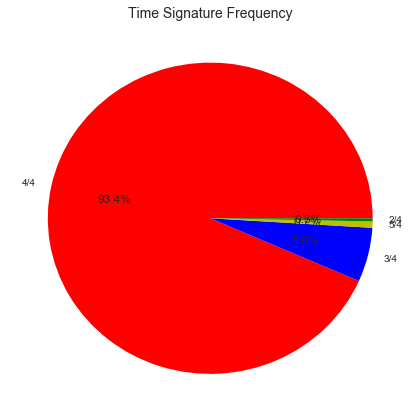

In [39]:
times = time_data.percent
colors = ['r','b' , 'y', 'g']
labels_time = ["4/4", "3/4", "5/4","2/4"]
fig, ax = plt.subplots(figsize=(6, 6))  # make the plot square
pie = ax.pie(times, colors=colors, labels=labels_time,autopct='%1.1f%%')
plt.title('Time Signature Frequency',fontsize=14)
plt.tight_layout()
plt.show()

** Here we see that the vast majority of songs on the Billboard Top 100 are written in 4/4 Time. **

## Has key popularity changed over time?

In [40]:
key_names = key_data[["key","mode","key_name"]]
key_merged = pd.merge(year_data,key_names, how="outer", left_on=["key","mode"],right_on=["key","mode"]).dropna()
key_year_new=key_merged.groupby(["year","key_name"]).count().reset_index()
key_subset=key_year_new[["year","key_name","chartDate"]]
key_pivot=key_subset.pivot_table(index=["year"],columns=["key_name"],values="chartDate")
key_pivot=key_pivot.fillna(0).reset_index()

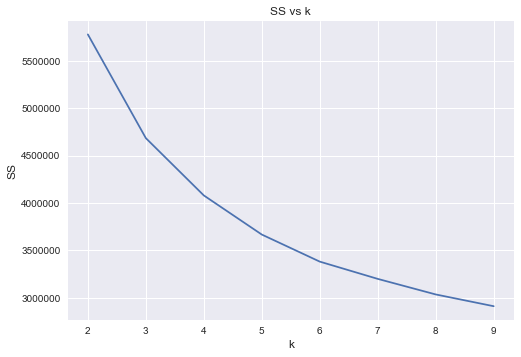

In [41]:
# Create a numpy matrix x_cols with only the columns representing the keys
x_cols = key_pivot[key_pivot.columns[1:]]
Ks = range(2, 10)
# Apply KMeans clustering for each k
km = [KMeans(n_clusters=k).fit(x_cols) for k in Ks]
# The sum-of-squares error in each cluster against KK
score = [-km[i].fit(x_cols).score(x_cols) for i in range(len(km))]
# Construct a plot showing SSSS for each KK and pick KK using this plot. For simplicity, test 2≤K≤102≤K≤10. 
plt.plot(Ks, score)
plt.xlabel('k', size=12)
plt.ylabel('SS', size=12)
plt.title('SS vs k')
plt.show()

** We choose k=4 for our number of clusters. **

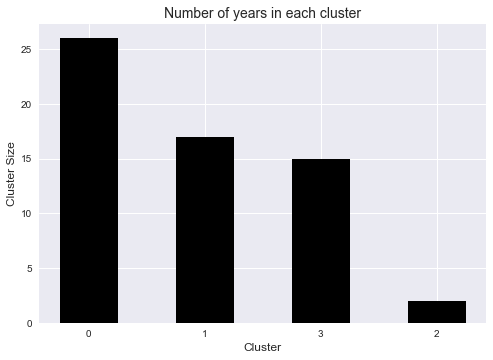

In [42]:
# We make a bar chart showing the number of points in each cluster for k-means under the best KK. 
# We use 4 for the best number of clusters.
key_pivot['cluster'] = KMeans(n_clusters=4).fit_predict(x_cols)
width = 1/2
y = pd.DataFrame(key_pivot.cluster.value_counts()).reset_index()
y.columns=["cluster","counted"]
x = np.arange(len(y))
plt.bar(x, y.counted, width, color="black")
plt.xticks(x,y.cluster)
plt.xlabel('Cluster', size=12)
plt.ylabel('Cluster Size', size=12)
plt.title('Number of years in each cluster',size=14)
plt.show()

**It's clear that cluster 2 represents the years 1958 and 2017 since there is less data for those years. What can we say about the other three clusters? **

In [43]:
key_cluster_zero=key_pivot[key_pivot.cluster==0]
key_cluster_one=key_pivot[key_pivot.cluster==1]
key_cluster_three=key_pivot[key_pivot.cluster==3]
print("Cluster zero:", key_cluster_zero.year.unique())
print("Cluster one:", key_cluster_one.year.unique())
print("Cluster three:", key_cluster_three.year.unique())

Cluster zero: [ 1959.  1960.  1961.  1962.  1963.  1964.  1965.  1966.  1967.  1968.
  1969.  1970.  1971.  1972.  1973.  1974.  1975.  1976.  1977.  1978.
  1979.  1980.  1981.  1982.  1984.  1988.]
Cluster one: [ 2000.  2001.  2002.  2003.  2004.  2005.  2006.  2007.  2008.  2009.
  2010.  2011.  2012.  2013.  2014.  2015.  2016.]
Cluster three: [ 1983.  1985.  1986.  1987.  1989.  1990.  1991.  1992.  1993.  1994.
  1995.  1996.  1997.  1998.  1999.]


** We have that cluster zero mostly represents the earlier years on the charts, cluster one represents the 80's and 90's and cluster three represents every year since 2000. **

In [44]:
cluster_zero_sum=key_cluster_zero.sum().reset_index()
cluster_zero_sum.columns=["key_name","counted"]
cluster_one_sum=key_cluster_one.sum().reset_index()
cluster_one_sum.columns=["key_name","counted"]
cluster_three_sum=key_cluster_three.sum().reset_index()
cluster_three_sum.columns=["key_name","counted"]

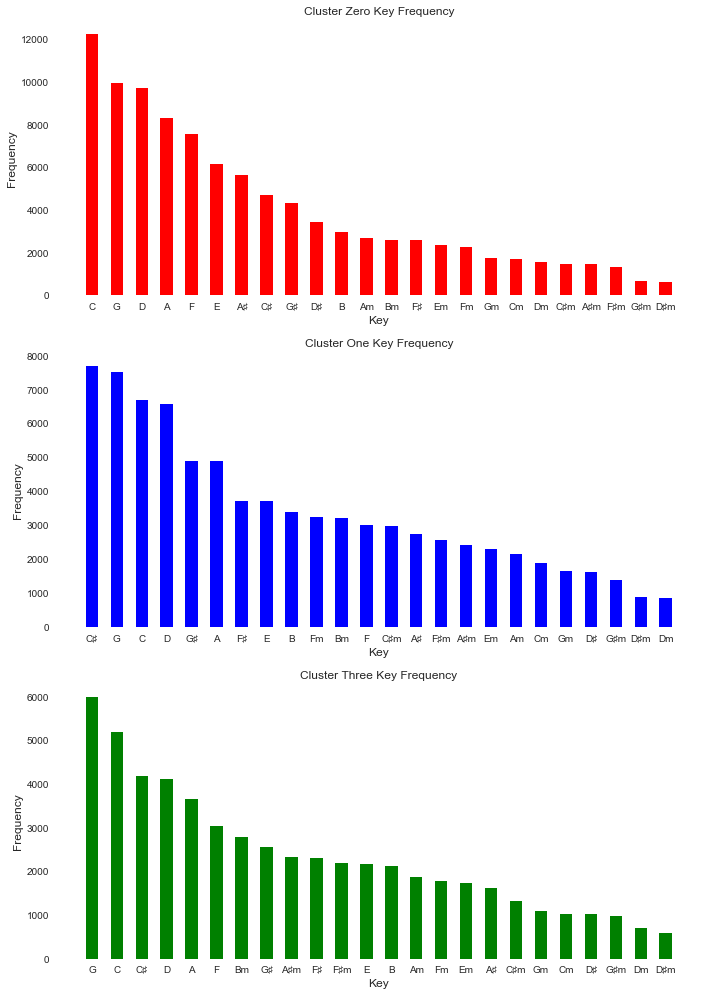

In [45]:
fig = plt.figure(figsize=(10, 14))
key_zero_sorted=cluster_zero_sum.sort_values(by="counted",ascending=False).reset_index(drop=True)
key_zero_sorted=key_zero_sorted[1:25]
key_list_zero_sorted=key_zero_sorted.key_name
y_pos = np.arange(len(key_list_zero_sorted))
axzero=plt.subplot(3,1,1)
axzero.spines["top"].set_visible(False)  
axzero.spines["right"].set_visible(False)
axzero.set_facecolor('white')
axzero.get_xaxis().tick_bottom()  
axzero.get_yaxis().tick_left()
plt.bar(y_pos, key_zero_sorted.counted, width=0.5,color="red")
plt.xticks(y_pos,key_zero_sorted.key_name)
plt.title("Cluster Zero Key Frequency")
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

axone=plt.subplot(3,1,2)
key_one_sorted=cluster_one_sum.sort_values(by="counted",ascending=False).reset_index(drop=True)
key_one_sorted=key_one_sorted[1:25]
key_list_one_sorted=key_one_sorted.key_name
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.bar(y_pos, key_one_sorted.counted, width=0.5,color="blue")
plt.xticks(y_pos,key_one_sorted.key_name)
plt.title("Cluster One Key Frequency")
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

axtwo=plt.subplot(3,1,3)
key_two_sorted=cluster_three_sum.sort_values(by="counted",ascending=False).reset_index(drop=True)
key_two_sorted=key_two_sorted[1:25]
key_list_two_sorted=key_two_sorted.key_name
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left()
plt.bar(y_pos, key_two_sorted.counted, width=0.5,color="green")
plt.xticks(y_pos,key_two_sorted.key_name)
plt.title("Cluster Three Key Frequency")
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

** One interesting discovery is that the key C♯ has become much more popular over time and is now the most popular key whereas D♯ has become the least popular major key and is not less popular than almost all minor keys. **

** Speculation**: Now that rock music is no longer the dominant genre it once was, there are less songs being written with piano and guitar in mind which may explain the decrease in the popularity of songs in C and G major. 

** Furthermore **: It would be very interesting to obtain reliable genre data for the Billboard Top 100 songs to see if this can explain the change in key popularity.

## What are some recent songs in the key of C♯?

In [46]:
csharp=year_data[(year_data["key"]==1) & (year_data["mode"]==1) & (year_data["year"]>1999)]
csharp_new=csharp.groupby(["title","artist"]).mean().reset_index()
csharp_sub=csharp_new[["title","artist"]]
csharp_sub.head(10)

,title,artist
0,(There's Gotta Be) More To Life,Stacie Orrico
1,***Flawless,Beyonce Featuring Nicki Minaj Or Chimamanda Ng...
2,24K Magic,Bruno Mars
3,4 My Town (Play Ball),Birdman Featuring Drake & Lil Wayne
4,A Case Of You,James Wolpert
5,Aaron s Party (Come Get It),Aaron Carter
6,Addicted,Simple Plan
7,Ain't Worried About Nothin,French Montana
8,All I Have,Jennifer Lopez Featuring LL Cool J
9,All Me,Drake Featuring 2 Chainz & Big Sean


## Are the audio metadata features different for more popular songs?

In [47]:
top_ten_songs=year_data_sub[year_data_sub.peakPos<11]
audio_means_ten=top_ten_songs.groupby("year").mean().reset_index()
bottom_ninety=year_data_sub[year_data_sub.peakPos>10]
audio_means_bottom=bottom_ninety.groupby("year").mean().reset_index()

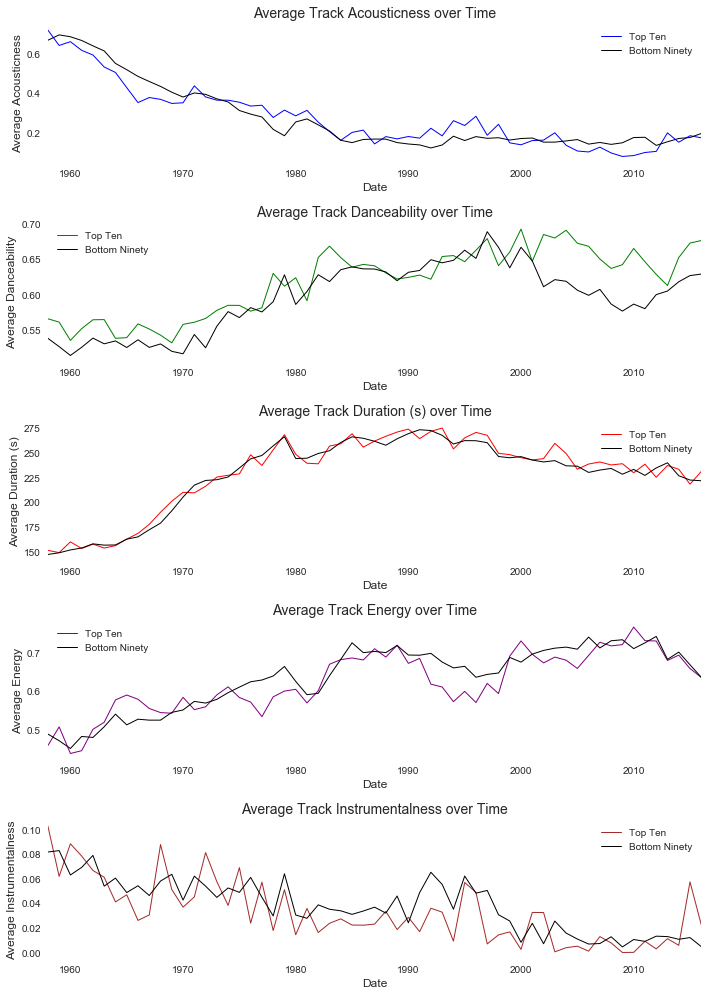

In [48]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.plot(audio_means_ten.year, audio_means_ten.acousticness, color="blue", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year, audio_means_bottom.acousticness, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Acousticness', fontsize=12)
plt.title('Average Track Acousticness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means_ten.year,audio_means_ten.danceability, color="green", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year,audio_means_bottom.danceability, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Danceability', fontsize=12)
plt.title('Average Track Danceability over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left()
plt.plot(audio_means_ten.year, audio_means_ten.duration_ms/1000, color="red", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year, audio_means_bottom.duration_ms/1000, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Duration (s)', fontsize=12)
plt.title('Average Track Duration (s) over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means_ten.year, audio_means_ten.energy, color="purple", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year, audio_means_bottom.energy, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Energy', fontsize=12)
plt.title('Average Track Energy over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means_ten.year,audio_means_ten.instrumentalness, color="brown", linewidth=1,label="Top Ten")
plt.plot(audio_means_bottom.year,audio_means_bottom.instrumentalness, color="black", linewidth=1,label="Bottom Ninety")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Instrumentalness', fontsize=12)
plt.title('Average Track Instrumentalness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

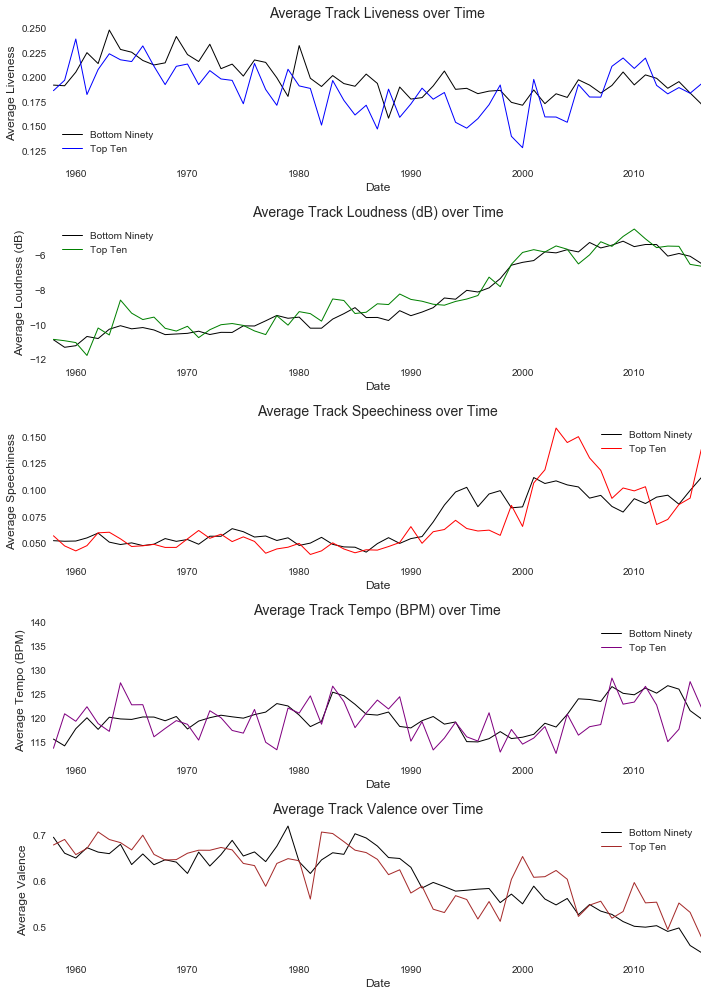

In [49]:
fig = plt.figure(figsize=(10, 14))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means_bottom.year, audio_means_bottom.liveness, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year, audio_means_ten.liveness, color="blue", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Liveness', fontsize=12)
plt.title('Average Track Liveness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means_bottom.year,audio_means_bottom.loudness, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year,audio_means_ten.loudness, color="green", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Loudness (dB)', fontsize=12)
plt.title('Average Track Loudness (dB) over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means_bottom.year, audio_means_bottom.speechiness, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year, audio_means_ten.speechiness, color="red", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Speechiness', fontsize=12)
plt.title('Average Track Speechiness over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means_bottom.year, audio_means_bottom.tempo, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year, audio_means_ten.tempo, color="purple", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Tempo (BPM)', fontsize=12)
plt.title('Average Track Tempo (BPM) over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means_bottom.year,audio_means_bottom.valence, color="black", linewidth=1,label="Bottom Ninety")
plt.plot(audio_means_ten.year,audio_means_ten.valence, color="brown", linewidth=1,label="Top Ten")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Valence', fontsize=12)
plt.title('Average Track Valence over Time', fontsize=14)
plt.legend()
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

** Interesting observations: ** After 2000 the danceability of tracks in the top ten have been much higher than the bottom ninety. On the other hand the liveness of tracks in the top ten have almost always been less on average than the bottom ninety. The speechiness of top ten tracks was much less than the bottom ninety in the 90's, but this switched in 2001 and for the duration of the 2000's it was much higher. A similar trend is found with valence. Top ten songs had a lower valence from the mid 80's until the late 90's (which could be somewhat related to the popularity of grunge?). Then in the 2000's the top ten tracks began to have higher valence than the bottom ninety.

## What are the most popular songs each year?

Here we're counting the song(s) that spent the most time at number one of that year as the most popular.

In [84]:
number_one_songs =year_data[year_data["rank"]==1].groupby(["artist","title", "year"]).count().reset_index()
number_one_year=number_one_songs.sort_values(by=["year","chartDate"],ascending=False)
number_one_index=number_one_year.groupby(['year'])['chartDate'].transform(max) == number_one_year['chartDate']
number_one_year = number_one_year.rename(columns={'chartDate': 'weeks_at_number_one'})
number_one_by_year= number_one_year[number_one_index][["year","artist","title","weeks_at_number_one"]].sort_values(by="year")

In [87]:
number_one_by_year[1:40]

,year,artist,title,weeks_at_number_one
115,1959,Bobby Darin,Mack The Knife,9
705,1960,Percy Faith And His Orchestra,The Theme From A Summer Place,9
117,1961,Bobby Lewis,Tossin' And Turnin',7
887,1962,The 4 Seasons,Big Girls Don't Cry,5
749,1962,Ray Charles,I Can't Stop Loving You,5
889,1962,The 4 Seasons,Sherry,5
426,1963,Jimmy Gilmer And The Fireballs,Sugar Shack,5
914,1964,The Beatles,I Want To Hold Your Hand,7
988,1965,The Rolling Stones,(I Can't Get No) Satisfaction,4
923,1965,The Beatles,Yesterday,4


In [91]:
number_one_by_year[41:78]

,year,artist,title,weeks_at_number_one
258,1986,Dionne,That s What Friends Are For,4
126,1987,Bon Jovi,Livin On A Prayer,4
852,1988,Steve Winwood,Roll With It,4
410,1989,Janet Jackson,Miss You Much,4
853,1990,Stevie B,Because I Love You (The Postman Song),4
830,1990,Sinead O Connor,Nothing Compares 2 U,4
572,1990,Mariah Carey,Vision Of Love,4
154,1991,Bryan Adams,"(Everything I Do) I Do It For You (From ""Robin...",7
132,1992,Boyz II Men,"End Of The Road (From ""Boomerang"")",13
1093,1993,Whitney Houston,"I Will Always Love You (From ""The Bodyguard"")",9


This gives us an indication of the songs that are associated with the audio metadata trends observed above.

# 8. Exploratory Lyrics Sentiment Analysis

## How many tracks have lyrics? From which sources? 

In [111]:
source_data=pd.DataFrame()
lyrics_count = len(lyrics_sub[lyrics_sub.source ==0])+len(lyrics_sub[lyrics_sub.source==1])
source_data = source_data.append({"source":"metrolyrics.com","lyrics count":lyrics_count},ignore_index=True)
lyrics_sources = ["songlyrics.com","lyricsmode.com","azlyrics.com","musixmatch.com"] 
for u in range(0,len(lyrics_sources)):
    lyrics_count = len(lyrics_sub[lyrics_sub.source ==u+2])
    source_data = source_data.append({"source":lyrics_sources[u],"lyrics count":lyrics_count},ignore_index=True)
no_lyrics= lyrics_sub[lyrics_sub.source.isnull()]
source_data=source_data.append({"source":"unavailable","lyrics count":len(no_lyrics)},ignore_index=True)
print("We have lyrics data for",len(lyrics_sub[lyrics_sub.lyrics.notnull()])/len(lyrics_sub)*100,"% of the tracks in the Billboard Top 100.")
source_data

We have lyrics data for 82.6047556908801 % of the tracks in the Billboard Top 100.


,lyrics count,source
0,14527,metrolyrics.com
1,6594,songlyrics.com
2,1650,lyricsmode.com
3,6,azlyrics.com
4,12,musixmatch.com
5,4799,unavailable


** Note: The reason azlyrics.com and musixmatch.com have such low lyrics counts besides being the 4th and 5th choices is because our IP was blocked after only a few attempts. **

## What are the most common words in the lyrics of each year?

In [112]:
lyrics_list=billboard_lyrics[billboard_lyrics.lyrics.notnull()].reset_index()
lower_limit =0
upper_limit =len(lyrics_list)
common_words = pd.DataFrame()
rgx = re.compile("(\w[\w']*\w|\w)")
for row in range(lower_limit,upper_limit):
    song_lyrics=lyrics_list.get_value(row,"lyrics")
    words = rgx.findall(song_lyrics)
    word_list = [word.lower() for word in words] 
    word_counts = Counter(word_list)
    add_frame = {"artist":lyrics_list.get_value(row,"artist"), "track":lyrics_list.get_value(row,"track"), "lyrics":song_lyrics,"common words":word_counts.most_common(), "year":}
    common_words = common_words.append(add_frame,ignore_index=True)

In [114]:
chart_year=year_data.groupby(["title","artist","lyrics","year"]).count().reset_index()
chart_sub=pd.merge(common_words,chart_year,left_on=["track","artist"],right_on=["title","artist"],how="outer")
chart_sub=chart_sub[["artist","common words","title","year"]].sort_values(by="year")

In [115]:
chart_sub.head(10)

,artist,common words,title,year
11232,Frankie Avalon,"[(oo, 24), (i, 11), (i'll, 6), (day, 6), (wait...",I'll Wait For You,1958
17973,Tommy Edwards,"[(love, 7), (me, 7), (don't, 6), (please, 5), ...",Please Love Me Forever,1958
16557,Gerry Granahan,"[(the, 21), (a, 16), (please, 11), (back, 11),...","No Chemise, Please",1958
22782,Bill Parsons,"[(a, 17), (and, 15), (i, 10), (all, 9), (my, 7...",The All American Boy,1958
26190,Kalin Twins,"[(i, 27), (you, 24), (when, 21), (me, 10), (wi...",When,1958
2338,Bobby Freeman,"[(betty, 33), (lou, 33), (a, 29), (new, 25), (...",Betty Lou Got A New Pair Of Shoes,1958
3834,Ray Price,"[(a, 12), (the, 7), (of, 5), (city, 5), (light...",City Lights,1958
25745,Jackie Wilson,"[(we, 12), (love, 12), (have, 11), (wonderful,...",We Have Love,1958
20891,Jodie Sands,"[(you, 14), (want, 12), (i, 9), (and, 8), (me,...",Someday (You'll Want Me To Want You),1958
16282,Bobby Freeman,"[(oh, 12), (so, 9), (bad, 7), (your, 6), (love...",Need Your Love,1958


In [127]:
yearly_common_words=pd.DataFrame()
year_min=int(chart_sub.year.min())
year_max=int(chart_sub.year.max())
year_current=year_min
row=0
year_count = Counter()
while year_current<year_max:
    year_check=chart_sub.iloc[row,3]
    if year_check==year_current:
        list_length=len(chart_sub.iloc[row,1])
        for i in range(0,list_length):
            year_count[chart_sub.iloc[row,1][i][0]] += 1        
    else:
        add_frame={"year":year_current,"common_words":year_count.most_common()}
        year_count = Counter()
        year_current+=1
        yearly_common_words=yearly_common_words.append(add_frame,ignore_index=True)
    row+=1

In [128]:
yearly_common_words.head(10)

,common_words,year
0,"[(the, 204), (and, 195), (i, 188), (you, 184),...",1958
1,"[(and, 393), (the, 385), (i, 373), (to, 353), ...",1959
2,"[(the, 432), (and, 416), (to, 396), (you, 391)...",1960
3,"[(the, 497), (to, 453), (i, 452), (you, 451), ...",1961
4,"[(the, 492), (and, 467), (i, 441), (you, 436),...",1962
5,"[(the, 471), (and, 455), (i, 443), (to, 443), ...",1963
6,"[(the, 501), (and, 496), (i, 495), (to, 487), ...",1964
7,"[(the, 536), (to, 515), (and, 510), (i, 500), ...",1965
8,"[(to, 527), (the, 521), (and, 515), (i, 508), ...",1966
9,"[(the, 544), (to, 518), (i, 504), (and, 498), ...",1967


** The most common words are of course small words that aren't very interesting. Let's remove these small common words and look for more distinctive words. **

In [142]:
s=set(stopwords.words('english'))
yearly_no_stops=pd.DataFrame()
for row in range(0,len(yearly_common_words)):
    year_count = Counter()
    list_length=len(yearly_common_words.iloc[row,0])
    for i in range(0,list_length):
        if yearly_common_words.iloc[row,0][i][0] not in s:
            year_count[yearly_common_words.iloc[row,0][i][0]] = yearly_common_words.iloc[row,0][i][1]        
    add_frame={"year":yearly_common_words.iloc[row,1],"common_words":year_count.most_common()}
    yearly_no_stops=yearly_no_stops.append(add_frame,ignore_index=True)

In [144]:
yearly_no_stops.head(10)

,common_words,year
0,"[(love, 137), (heart, 85), (oh, 82), (i'm, 79)...",1958
1,"[(love, 257), (i'm, 185), (know, 160), (oh, 13...",1959
2,"[(love, 287), (know, 192), (i'm, 191), (oh, 16...",1960
3,"[(love, 337), (i'm, 242), (know, 237), (oh, 21...",1961
4,"[(love, 305), (know, 255), (i'm, 232), (oh, 21...",1962
5,"[(love, 304), (i'm, 249), (know, 244), (oh, 22...",1963
6,"[(love, 307), (know, 269), (i'm, 255), (don't,...",1964
7,"[(love, 333), (know, 261), (i'm, 256), (don't,...",1965
8,"[(love, 336), (i'm, 274), (know, 269), (don't,...",1966
9,"[(love, 327), (i'm, 271), (know, 264), (don't,...",1967


In [147]:
for row in range(0,len(yearly_no_stops)):
    popular_words=""
    for i in range(0,15):
        popular_words+=yearly_no_stops.iloc[row,0][i][0]+", "
    print("year:", yearly_no_stops.iloc[row,1], "| top words:",popular_words)

year: 1958.0 | top words: love, heart, oh, i'm, know, one, don't, like, come, you're, time, it's, little, day, see, 
year: 1959.0 | top words: love, i'm, know, oh, heart, don't, like, come, one, go, you're, got, i'll, see, night, 
year: 1960.0 | top words: love, know, i'm, oh, heart, don't, like, one, go, you're, never, come, way, i'll, it's, 
year: 1961.0 | top words: love, i'm, know, oh, don't, heart, like, go, it's, one, never, you're, come, see, say, 
year: 1962.0 | top words: love, know, i'm, oh, don't, it's, like, heart, one, go, time, see, say, you're, never, 
year: 1963.0 | top words: love, i'm, know, oh, don't, one, say, go, like, heart, come, it's, you're, got, see, 
year: 1964.0 | top words: love, know, i'm, don't, oh, one, say, heart, see, go, it's, i'll, you're, like, come, 
year: 1965.0 | top words: love, know, i'm, don't, it's, oh, say, like, one, see, baby, go, heart, can't, come, 
year: 1966.0 | top words: love, i'm, know, don't, baby, it's, you're, oh, come, one, see,

** While the number of words in the stopwords corpus is small so we are still getting a lot of very small uninteresting common words showing up in the list. It is interesting to see that "love" was usually the most common word throughout the 60's and 70's whereas through the 90's and 2000's "i'm" has become the most common word. Does this mean that love songs have become less popular? Is this related to the decrease in the average valence of songs in the Top 100? **

# 9. Conclusion and Future Investigation

We find that a very noticable shift occurred in the Billboard Top 100 in the late 90's, most likely as a result of the internet and the policy change to allow non-single tracks to be counted on the charts. This has resulted in the most popular songs belonging to a handful of artists and an overall decrease in the number of one-hit wonders released each year. The decline in the popularity of rock music has also lead to a change in overall key popularity. We note that Top 100 songs have become less acoustic, less instrumental and less positive on average over time while also becoming louder and with more speech.

Things we will investigate in the future is if lyrical sentiment has any relationship to audio "sentiment" measure by valence and if sentiment is also an indicator of song popularity.
